In [81]:
from string import digits
import acquire
import prepare
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import itertools
import re
import unicodedata
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(8, 10))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Notes on Prepare/ Acquire: Create the URL's

- Focused on URL's that were identified as JavaScript or Python
- Opened up searh URL on GitHub, added URLs that fit discription untill 105 were sampled
- Ended on search page 39

## Acquire/Prepare:

In [2]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 2), (21, 2), (21, 2))

In [3]:
# Lets see what we are playing with
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

javascript    34
python        29
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64


,language,text_filtered
52,python,introduction reposado set tool written python ...
90,javascript,flowcoveragereport flowcoveragereport node com...
91,javascript,react native storybook content repo wa moved s...
11,python,sqlalchemy python sql toolkit object relationa...
70,python,visual studio documentation welcome repo conta...


## Explore:


1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

### Question #1. What are the most common words in READMEs?

In [4]:
# Break it down by language
#train['language'] = train['language'].str.strip()

In [5]:
# Create a corpus of all text
all_words = ' '.join(train.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)

In [6]:
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

pod        434
new        162
command    161
see        159
name       156
dtype: int64

#### Javascript only

In [7]:
# Break it down by language (Javascript)
mask = train.language == 'javascript'
java_df = train[mask]
# Create a corpus of all text
all_words = ' '.join(java_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

pod          434
label        136
container    136
node         135
new          113
dtype: int64

In [8]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
pod,434
label,136
container,136
node,135
new,113
name,110
option,109
kubectl,109
running,108
see,106


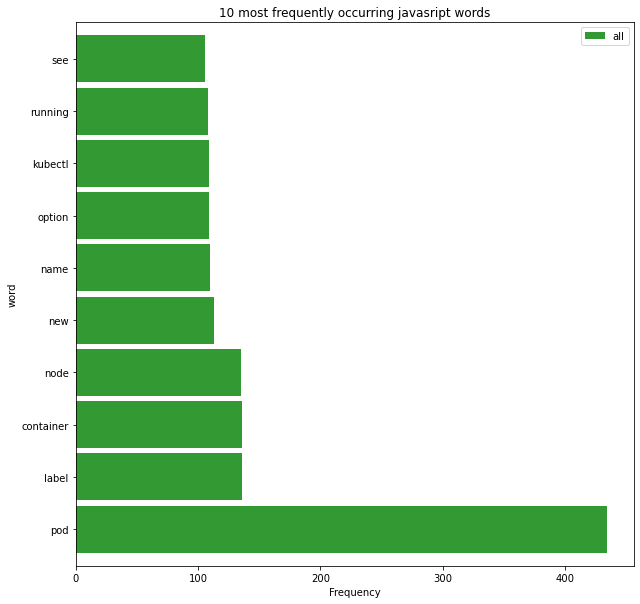

In [9]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='green', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring javasript words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

****

#### Python Only

In [10]:
# Break it down by language (Python)
mask = train.language == 'python'
python_df = train[mask]
python_df.head()
# Create a corpus of all text
all_words = ' '.join(python_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

model      104
git         95
python      95
layer       84
command     83
dtype: int64

In [11]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
model,104
python,95
git,95
layer,84
command,83
code,77
repo,66
install,63
repository,60
ggshield,59


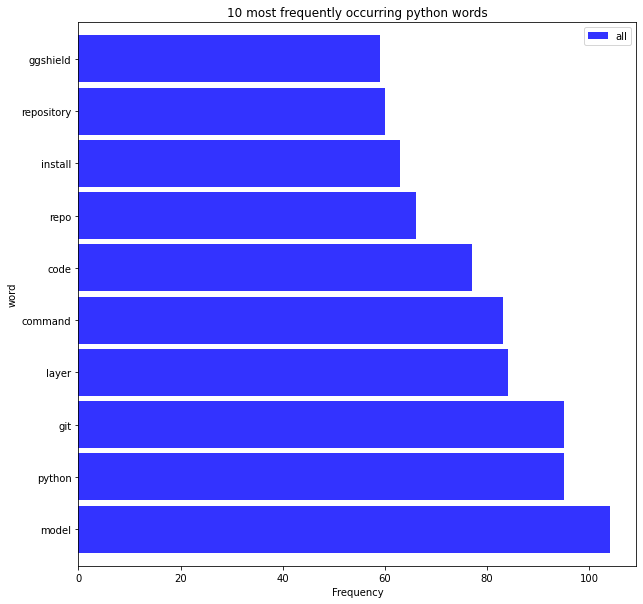

In [12]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='blue', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring python words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

#### Combined 

In [13]:
# Create Corpus
javascript_words = ' '.join(train[train.language =='javascript'].text_filtered)
python_words = ' '.join(train[train.language =='python'].text_filtered)
all_words = ' '.join(train.text_filtered)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore corpus
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()
word_counts = (pd.concat([all_freq, javascript_freq, python_freq], axis=1, sort=True)
               .set_axis(['all', 'javascript', 'python'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )


# How often to words occur across repos
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
new,162,113,49
command,161,78,83
see,159,106,53
name,156,110,46
option,148,109,39
label,148,136,12
node,140,135,5
code,139,62,77
container,136,136,0


In [14]:
# Any words specific only to javascript and never in python?
word_counts[word_counts.python == 0].sort_values(by='javascript', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
container,136,136,0
kubectl,109,109,0
replicationcontroller,86,86,0
callback,70,70,0
npm,59,59,0
selector,59,59,0
probe,57,57,0
params,51,51,0
listing,45,45,0


In [15]:
# Any words specific only to python and never in javascript?
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False).head(10)

,all,javascript,python
model,104,0,104
layer,84,0,84
ggshield,59,0,59
deeplift,52,0,52
score,49,0,49
gita,48,0,48
emotion,38,0,38
bucket,34,0,34
ipython,31,0,31
s3cmd,31,0,31


In [16]:
# These might be words to excude to make modeling easier
word_counts[word_counts.javascript == word_counts.python].sort_values(by='python', ascending=False).head(10)

,all,javascript,python
faq,10,5,5
defined,10,5,5
approach,10,5,5
handle,10,5,5
includes,10,5,5
algorithm,10,5,5
style,10,5,5
according,10,5,5
map,10,5,5
env,10,5,5


****
#### Takeaway:

`1. Top 10 Javascript words (file, option, use, npm, using, run, callback, meta, new, install)`   
`2. Top 10 Python words     (file, video, use, youtubed, download, git, formatt, python, run, command)`    
`3. Common words, bad for modeling (file, use, run, using, example)`     
`4. Most common words (Corpus) = Most Common words for specific languages`    

`May remove flie, use, run, using, example from corpus`   

****

### Question #2. What does the distribution of IDFs look like for the most common words?

In [17]:
#Inverse Documnet Frequency; a measure based on in how many documents will a word appear.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)

In [18]:
# Get vocabularies.
tfidf.vocabulary_

{'set': 37,
 'python': 33,
 'update': 42,
 'license': 20,
 'new': 26,
 'user': 44,
 'feature': 12,
 'create': 8,
 'number': 29,
 'available': 1,
 'test': 40,
 'version': 45,
 'information': 17,
 'command': 6,
 'help': 16,
 'project': 32,
 'code': 5,
 'check': 4,
 'install': 18,
 'npm': 28,
 'build': 2,
 'default': 10,
 'path': 31,
 'following': 13,
 'used': 43,
 'source': 38,
 'issue': 19,
 'ha': 15,
 'change': 3,
 'support': 39,
 'github': 14,
 'data': 9,
 'repo': 34,
 'content': 7,
 'work': 47,
 'time': 41,
 'like': 21,
 'need': 25,
 'make': 24,
 'development': 11,
 'repository': 35,
 'open': 30,
 'request': 36,
 'add': 0,
 'list': 22,
 'want': 46,
 'look': 23,
 'note': 27}

***
#### Takeaway:
`1. Many of the words are overlap are found in many documents, further evidence that they should be removed befor modeling`

***

### Question #3. Does the length of the README vary by programming language?

In [19]:
# Count lenght of readme text
train['doc_length'] = [len(wordlist) for wordlist in train.text_filtered]
train.head()

,language,text_filtered,doc_length
52,python,introduction reposado set tool written python ...,1746
90,javascript,flowcoveragereport flowcoveragereport node com...,6372
91,javascript,react native storybook content repo wa moved s...,290
11,python,sqlalchemy python sql toolkit object relationa...,3484
70,python,visual studio documentation welcome repo conta...,801


In [20]:
# Create df
mask = train['language'] == 'python'
python_train = train[mask]
mask = train['language'] == 'javascript'
javascript_train = train[mask]
python_train.shape, javascript_train.shape

((29, 3), (34, 3))

In [21]:
#Ave doc_lenth(python)
pmean= (python_train.doc_length).mean()
pmean

4371.827586206897

In [22]:
#Ave doc_lenth(javascript)
jmean=(javascript_train.doc_length).mean()
jmean

4532.64705882353

#### Hypothesis Test (2 Sample T-Test)

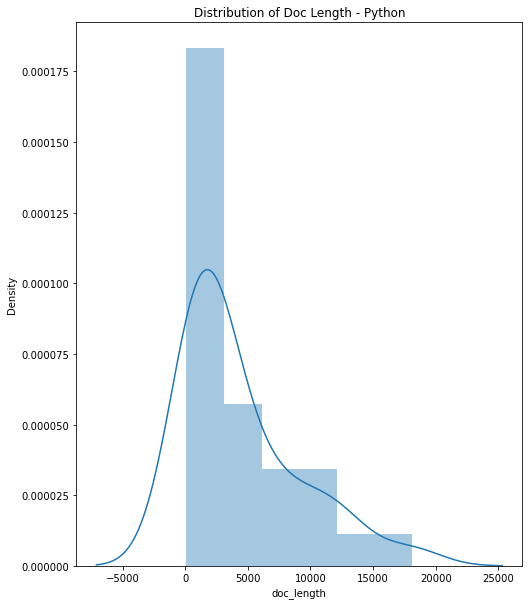

In [23]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(python_train.doc_length)
plt.title('Distribution of Doc Length - Python')
plt.show()

In [24]:
python_train.describe()

,doc_length
count,29.000000
mean,4371.827586
std,4682.650631
min,70.000000
25%,1028.000000
50%,2207.000000
75%,6117.000000
max,18139.000000


***

`Python Data is NOT evenly distributed`

***

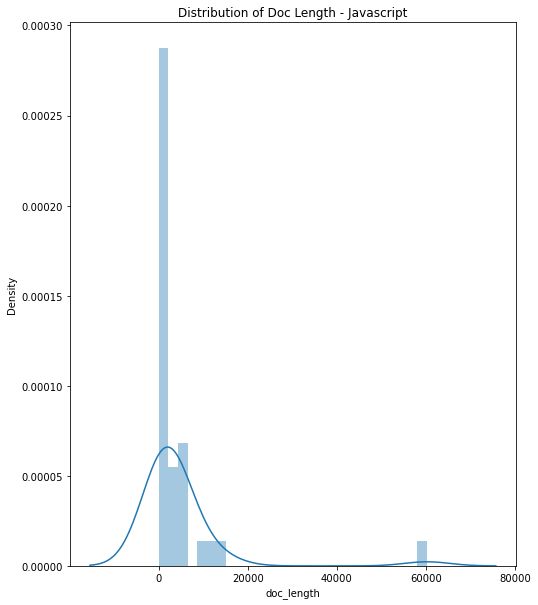

In [25]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(javascript_train.doc_length)
plt.title('Distribution of Doc Length - Javascript')
plt.show()

In [26]:
javascript_train.describe()

,doc_length
count,34.000000
mean,4532.647059
std,10409.172121
min,42.000000
25%,812.250000
50%,1511.500000
75%,4394.250000
max,60215.000000


***

`Javascript Data is NOT evenly distributed`

***

In [27]:
# Variance (2 Sample T-Test)
print(python_train.doc_length.var())
print(javascript_train.doc_length.var())

21927216.93349753
108350864.23529415


***
`Variance is not equal, need to set in function call`
***

#### Null and Alternate

In [28]:
null = "there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md"
alternate = "there is a statisically significant difference between between the length of python repo README.md and javascript repo README.md"

In [29]:
# I want a 95% confidence interval
alpha = 0.05

#### T-Test

In [30]:

t, p = stats.ttest_ind(python_train.doc_length , javascript_train.doc_length, equal_var =False)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')
print("is p < alpha? ", p < alpha)
print("is t > 0? ", t > 0)
if p > alpha:
    print(f"We fail to reject that {null}")
elif t < 0:
    print(f"We fail to reject that {null}")
else:
    print(f"WE REJECT that {null}")


t = -0.081
p = 0.936
is p < alpha?  False
is t > 0?  False
We fail to reject that there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md


***

In [31]:
python_train.shape, javascript_train.shape

((29, 3), (34, 3))

### Question #4. Do different programming languages use a different number of unique words?

In [32]:
# Create list of word lists(python_train)
pwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in python_train.text_filtered]
# Combine those lists in to a single list
pwords = list(itertools.chain.from_iterable(pwords))


# Create list of word lists(javascript_train)
jwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in javascript_train.text_filtered]
# Combine those lists in to a single list
jwords = list(itertools.chain.from_iterable(jwords))

# Returns words unique to python
unique_pwords = list(set(pwords) - set(jwords))
# Returns words unique to javascript
unique_jwords = list(set(jwords) - set(pwords))

#### Words Unique to Python Repositories

In [33]:
print(len(unique_pwords))
unique_pwords

3140


['diafygi',
 'aclpublic',
 'tensorboardx',
 'doodle',
 'conducted',
 'pltxlabelsentence',
 'readily',
 'predicting',
 'osdependent',
 'leverage',
 's3publics3toolsorgsomewheredir1file11txt5',
 'repoable',
 'booktitlethe',
 'youtubedl',
 'hourly',
 'inputlayergetreferencevars',
 'win64',
 'apenwarr',
 'prereceivepythonsample',
 'reposync',
 'study',
 'modeling',
 '7212',
 'needle',
 'accidental',
 'targetlayeridxdefault',
 'statistic',
 'pokemongof',
 '11269the',
 'opentranscriptcleantxtencodingutf8',
 'coercion',
 'zimmermann2018',
 'overridehelp',
 'dataxmodelnetcls',
 'logits',
 'ulidtko',
 'colorize',
 'dwf',
 'recognition',
 'sisr2',
 'humanlabeled',
 'tar',
 'personar',
 'texture',
 'python3',
 'squeezenet',
 'methodlrp',
 'march',
 'naive',
 'pyspider',
 'git2240',
 'userfriendly',
 'psnr',
 '50k',
 'chatbot',
 'characteree',
 'httpsgithubcomkundajelabdeepliftgit',
 'somewheredir1',
 'reasonfirst',
 'june',
 'mutlimodal',
 '283',
 'setscoringmode',
 'prune',
 'classified',
 'pred

In [34]:
print(len(unique_jwords))
unique_jwords

2862


['nanofollowupdatessince',
 'gitgithubcomdscapenanogit',
 'directive',
 'nodecanvas',
 'heal',
 'consoleloggot',
 'testcodeevaluatefilejs',
 'spec',
 'testdata',
 'delay',
 'goto',
 'abort',
 'seem',
 'foot',
 'earn',
 'protected',
 'binwatch',
 'completable',
 'assertion',
 'constrain',
 'misconfigured',
 'envdevel',
 'converter',
 'solid',
 '109601',
 'isolation',
 'localhost8080',
 'getrabbitrev42e6cdc4c7e26b745c2881a24e0eeece2',
 'lifting',
 'ok',
 'unambiguously',
 'maxkeepaliverequestsmaxkeepalivetime',
 'hot',
 'spark',
 'semicolon',
 'curly',
 'testacular',
 'kubiahttp',
 'playground',
 'navigate',
 'testfixturesintegrationdirwithsecrets',
 'impact',
 'effortless',
 'ahlquist',
 'fame',
 'ajax',
 'kubiacontainer',
 'rely',
 'appending',
 '12150985a725ec88be471921a54ce91452',
 'heat',
 'callbackerr',
 'begin',
 'dbfollowsince',
 'official',
 'schiffer',
 'lambda',
 'optsbody',
 'https192168991008443',
 'initially',
 'clientsidego',
 'customnamespace',
 'arising',
 'errmessage',


***
#### Takwaway:
`There appear to be more words unique to python repositories.  This makes sense because the length of python README.md text is statistically longer then javascript README.md text.`
***

## Modeling:

In [35]:
train.head()

,language,text_filtered,doc_length
52,python,introduction reposado set tool written python ...,1746
90,javascript,flowcoveragereport flowcoveragereport node com...,6372
91,javascript,react native storybook content repo wa moved s...,290
11,python,sqlalchemy python sql toolkit object relationa...,3484
70,python,visual studio documentation welcome repo conta...,801


In [36]:
#Baseline
train.language.value_counts()

javascript    34
python        29
Name: language, dtype: int64

In [37]:
# Baseline prediction javascript
baseline = round(len(train[train.language == 'javascript']) / len(train), 2)
baseline

0.54

In [38]:
# Baseline prediction python
baseline = round(len(train[train.language == 'python']) / len(train), 2)
baseline

0.46

In [39]:
#Import some clean data for modeling
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)

#### Bag of Words Model

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature(20). 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=4, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.text_filtered)
# Transform each sentences in vector space.
bow = vectorizer.transform(train.text_filtered)

#### TF-IDF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=4, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf.fit(train.text_filtered)
tfidf_sparse_matrix = tfidf.transform(train.text_filtered)

***

#### Train (BOW)

In [42]:
from sklearn.linear_model import LogisticRegression

# Define x and y variable
X_bow = bow
y = train['language']

lm = LogisticRegression().fit(X_bow, y)
train['predicted'] = lm.predict(X_bow)

In [43]:
# Results(train)
pd.crosstab(train.language, train.predicted)

predicted,javascript,python
language,,
javascript,34,0
python,0,29


In [44]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(train.language, train.predicted))

              precision    recall  f1-score   support

  javascript       1.00      1.00      1.00        34
      python       1.00      1.00      1.00        29

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



#### Train (TF-IDF)

In [45]:
# Define x and y variable

X_tfidf = tfidf_sparse_matrix
y = train['language']

lm_tfidf = LogisticRegression().fit(X_tfidf, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf)

In [46]:
# Results(train)
pd.crosstab(train.language, train.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,34,0
python,0,29


In [47]:
print(classification_report(train.language, train.pred_tfidf))

              precision    recall  f1-score   support

  javascript       1.00      1.00      1.00        34
      python       1.00      1.00      1.00        29

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



***

#### Validate (BOW)

In [48]:
# Validate
bow = vectorizer.transform(validate.text_filtered)
X_bow_validate = bow
y = validate['language']
validate['predicted'] = lm.predict(X_bow_validate)

In [49]:
# Results(validate)
pd.crosstab(validate.language, validate.predicted)

predicted,javascript,python
language,,
javascript,10,2
python,2,7


In [50]:
print(classification_report(validate.language, validate.predicted))

              precision    recall  f1-score   support

  javascript       0.83      0.83      0.83        12
      python       0.78      0.78      0.78         9

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21



#### Validate (TF-IDF)

In [51]:
tfidf_sparse_matrix = tfidf.transform(validate.text_filtered)
X_tfidf_validate = tfidf_sparse_matrix
y = validate['language']
validate['pred_tfidf'] = lm.predict(X_tfidf_validate)

In [52]:
# Results(validate)
pd.crosstab(validate.language, validate.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,6,6
python,0,9


In [53]:
print(classification_report(validate.language, validate.pred_tfidf))

              precision    recall  f1-score   support

  javascript       1.00      0.50      0.67        12
      python       0.60      1.00      0.75         9

    accuracy                           0.71        21
   macro avg       0.80      0.75      0.71        21
weighted avg       0.83      0.71      0.70        21



***

#### Takeaway:

`Scores drop in validate when trying to identify python repositoreis.  Going back to remove common words between repositories to imporove scores on validate before test.`

***

#### Test (TF-IDF)

In [54]:
tfidf_sparse_matrix = tfidf.transform(test.text_filtered)
X_tfidf_test = tfidf_sparse_matrix
y = test['language']
test['pred_tfidf'] = lm.predict(X_tfidf_test)

In [55]:
# bow = vectorizer.transform(test.text_filtered)
# X_bow_test = bow
# y = test['language']
# test['predicted'] = lm.predict(X_bow_test)

In [56]:
# Results(test)
pd.crosstab(test.language, test.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,9,3
python,0,9


In [57]:
print(classification_report(test.language, test.pred_tfidf))

              precision    recall  f1-score   support

  javascript       1.00      0.75      0.86        12
      python       0.75      1.00      0.86         9

    accuracy                           0.86        21
   macro avg       0.88      0.88      0.86        21
weighted avg       0.89      0.86      0.86        21



***


***

## Modeling Summary:

***

1. 1st Round - 2 Models (Bag of Words, TF-IDF)   
   - Default paramaters   
   - `Bag of Words Model:`   
       - Train (98% Accuracy)   
       - Validate (71% Accuracy)   
   - `TF-IDF Model:`   
       - Train (98% Accuracy)   
       - Validate (71% Accuracy)   
       
#### Model accuracy fell, went back and deleted common words, no change when re-ran the model   
***

2. 2nd Round - 2 Models (Bage of Words, TF-IDF)
    - Modified paramaters (min_df) reduced to 5 - elminates words that have a document frequency less than 5
    -`Bag of Words Model:`
       - train (100% Accuracy) 
       - validate(86% Accuracy)
    -`TF-IDF Model:`
       - train (100% Accuracy)
       - validate(81% Accuracy)

#### Better, but model still struggled to pick up on python repos consistantly (Maybe no signal to pick up on, with small dataset)
***

3. 3rd Round - Same as 2nd, but reduced (min_df) to 4
      - Model preformace imporve on python repos moved (TF-IDF) to test
      - Model was able to pick up python repos consistantly for the firs time.  
      
***

## Next Steps:

1. Apply model to larger training dataset, and test again
2. Create function that takes a repo address and predicts language

In [58]:
#Import some clean data for modeling
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)

In [59]:
# Resample data to expand train and retest
from sklearn.model_selection import train_test_split

def train_test(df):
    train, test = train_test_split(df[['language', 'text_filtered']], 
                                            random_state = 123,
                                            stratify=df.language, 
                                            test_size=.2)
    return train, test

In [60]:
train, test = train_test(df)
train.shape, test.shape

((84, 2), (21, 2))

#### TF-IDF

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Make Model
tfidf = TfidfVectorizer(stop_words='english', min_df=4, 
                             ngram_range=(1,2), 
                             binary=True)
#Fit Model
tfidf.fit(train.text_filtered)

tfidf_sparse_matrix = tfidf.transform(train.text_filtered)

#### Train

In [74]:
# Define x and y variable
tfidf_sparse_matrix = tfidf.transform(train.text_filtered)
X_tfidf_train = tfidf_sparse_matrix
y = train['language']

lm_tfidf = LogisticRegression().fit(X_tfidf_train, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf_train)


In [75]:
# Results(train)
pd.crosstab(train.language, train.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,46,0
python,0,38


In [71]:
print(classification_report(train.language, train.pred_tfidf))

              precision    recall  f1-score   support

  javascript       1.00      1.00      1.00        46
      python       1.00      1.00      1.00        38

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



#### Test

In [77]:
tfidf_sparse_matrix = tfidf.transform(test.text_filtered)
X_tfidf_test = tfidf_sparse_matrix
y = test['language']

test['pred_tfidf'] = lm_tfidf.predict(X_tfidf_test)

In [78]:
# Results(test)
pd.crosstab(test.language, test.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,12,0
python,5,4


In [79]:
print(classification_report(test.language, test.pred_tfidf))

              precision    recall  f1-score   support

  javascript       0.71      1.00      0.83        12
      python       1.00      0.44      0.62         9

    accuracy                           0.76        21
   macro avg       0.85      0.72      0.72        21
weighted avg       0.83      0.76      0.74        21

